## Data Exploration
<b>Objective:</b> Explore astronomical lightcurves from the Photometric LSST Astronomical Time-Series Classification Challenge, reading data from [Kaggle](https://www.kaggle.com/c/PLAsTiCC-2018/data) `csv` files.

In [1]:
# Imports

# Standard
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Auxilliary
import george
from george import kernels

from scipy.optimize import minimize

In [2]:
print(george.__file__)

/astro/users/lfulmer/.conda/envs/earthseed/lib/python3.8/site-packages/george/__init__.py


In [3]:
# Settings
rcParams['figure.figsize'] = [6.5, 6.5]
rcParams['font.size'] = 10

In [4]:
# PLAsTiCC Data
# object_id, mjd, passband, flux, flux_err, detected
train = pd.read_csv("../plasticc/training_set.csv")

# object_id, ra, decl, gal_l, gal_b, ddf, hostgal_specz, hostgal_photoz, hostgal_photoz_err, distmod, mwebv, target
train_meta = pd.read_csv("../plasticc/training_set_metadata.csv")

### How many known classes are in the training set?

In [5]:
classes = train_meta['target'].unique()
classes.sort()

print("There are {} known classes in the PLAsTiCC training set. \nClasses are labeled as {}"\
      .format(len(classes), classes))

There are 14 known classes in the PLAsTiCC training set. 
Classes are labeled as [ 6 15 16 42 52 53 62 64 65 67 88 90 92 95]


### How many objects are in each class?

In [6]:
class_sizes = [len(train_meta['object_id'][train_meta['target'] == cl]) for cl in classes]

size_sort = np.argsort(class_sizes)
classes_str_sort = np.zeros(len(size_sort), dtype=int) 
class_sizes_sort = np.zeros(len(size_sort), dtype=int) 

# Populate list of class labels (strings) and sizes for all classes
for i in range(0, len(size_sort)): 
    classes_str = [str(i) for i in classes] 
    classes_str_sort[i] = classes_str[size_sort[i]] 
    class_sizes_sort[i] = class_sizes[size_sort[i]]

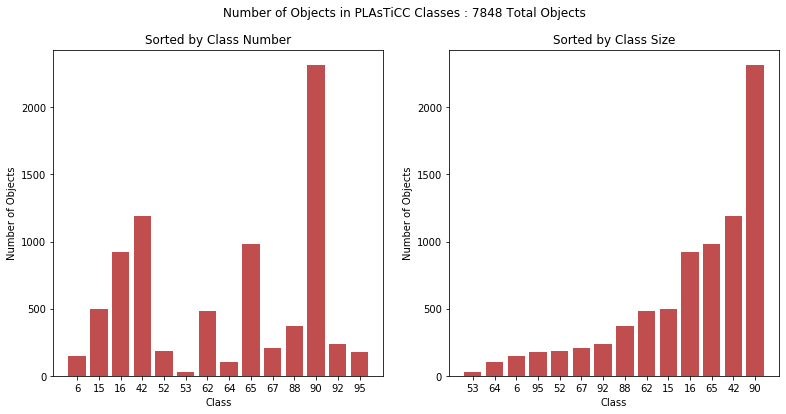

In [7]:
# Plot
n_classes = np.arange(len(classes))

plt.figure(figsize=(13, 6))
plt.subplot(1,2,1)
plt.bar(n_classes, class_sizes, align='center', alpha=0.8, color = 'firebrick')
plt.xticks(n_classes, classes_str)
plt.xlabel('Class')
plt.ylabel('Number of Objects')
plt.title('Sorted by Class Number')

plt.subplot(1,2,2)
plt.bar(n_classes, class_sizes_sort, align='center', alpha=0.8, color = 'firebrick')
plt.xticks(n_classes, classes_str_sort)
plt.xlabel('Class')
plt.ylabel('Number of Objects')
plt.title('Sorted by Class Size')
# plt.title('Number of Objects in PLAsTiCC Classes')

plt.suptitle("Number of Objects in PLAsTiCC Classes : {} Total Objects".format(sum(class_sizes)))
plt.show()

### What are the redshifts of objects in each class?

All redshifts for Class 6 set to 0.0
All redshifts for Class 16 set to 0.0
All redshifts for Class 53 set to 0.0
All redshifts for Class 65 set to 0.0
All redshifts for Class 92 set to 0.0


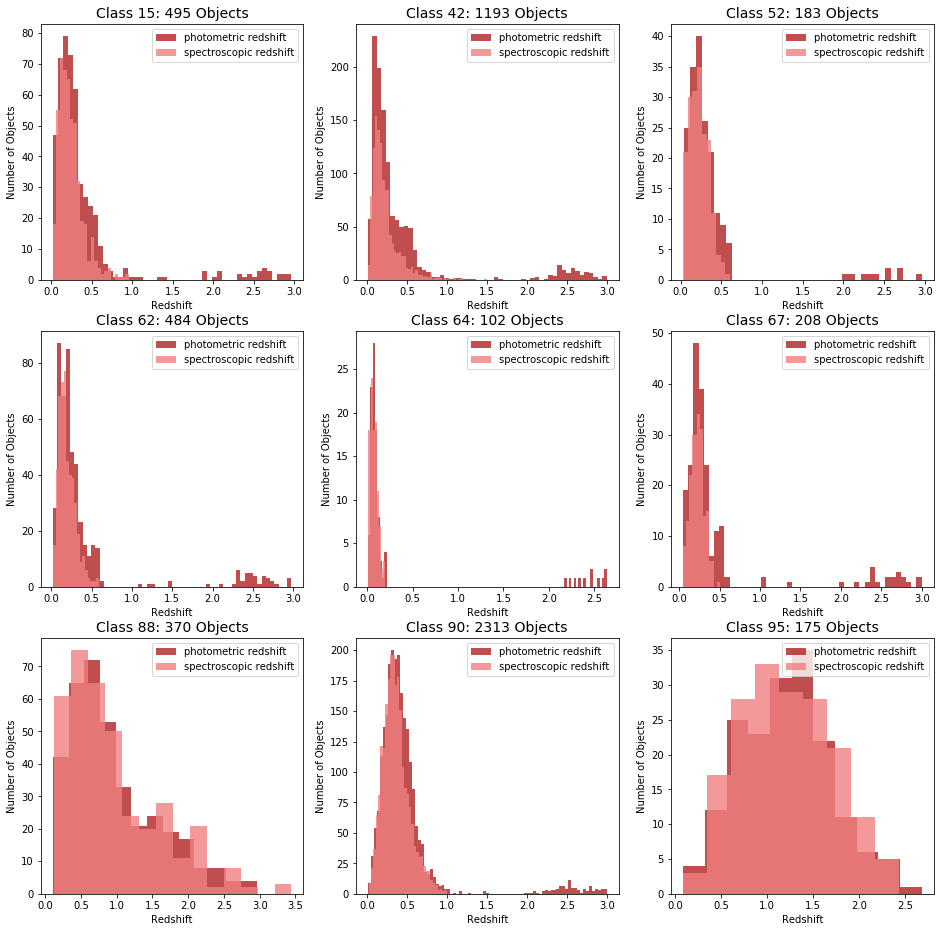

In [8]:
speczs = [train_meta['hostgal_specz'][train_meta['target'] == cl] for cl in classes]
photozs = [train_meta['hostgal_photoz'][train_meta['target'] == cl] for cl in classes]

plt.figure(figsize=(16,16))
j = 1

for i, individual_class in enumerate(classes):
    if max(photozs[i]) == 0.0:
        print(f'All redshifts for Class {individual_class} set to 0.0')
    else: 
        plt.subplot(3,3,j)
        plt.hist(photozs[i], bins = 'fd', color='firebrick', label='photometric redshift', alpha = 0.8)
        plt.hist(speczs[i], bins = 'fd', color='lightcoral', label='spectroscopic redshift', alpha = 0.8)
        plt.xlabel('Redshift')
        plt.ylabel('Number of Objects')
        plt.title(f'Class {individual_class}: {class_sizes[i]} Objects',size=14)
        plt.legend(loc='upper right', ncol=1)
        j += 1
plt.show()

Most objects within the PLAsTiCC training set are only observed at low redshifts. In order to represent the full range of observations within the testing set, we will need to augment the training set.

### What do the lightcurves really look like?

In [9]:
# I would love to use groupby here, but I don't know why it's not working. I don't understand what isin does
# that groupby doesn't do. I also don't understand groupby fundamentally.

# Let's look at the data by individual class
# Create a dictionary of classes and pull all of the training data (every single observation) for each class
data_by_class = {cl : train[train['object_id'].isin(train_meta['object_id'][train_meta['target'] == cl])] \
                for cl in classes}

# ... and look at the objects by class
# Determine the unique objects within an individual class
objects_by_class = {cl : data_by_class[cl]['object_id'].unique() \
                  for cl in classes}

# ... and lightcurves by class
# Sort all the data by object
lightcurves_by_class = { cl : [ data_by_class[cl][data_by_class[cl]['object_id'] == o] for o in objects_by_class[cl] ] \
                       for cl in classes }

In [10]:
# Separate the lightcurves for each passband
def lightcurves_by_passband(data):
    return [ data[data['passband'] == i] for i in data['passband'].unique() ]

def lightcurves_collect_passbands(data, passbands):
    if type(passbands) == int:
        return data[data['passband'] == passbands ]
    
    observations = pd.DataFrame(columns = data.columns)
   
    for i in range(len(data)):
        if data.iloc[i]['passband'] in passbands:
            observation = pd.DataFrame([data.iloc[i]], columns=data.columns)
            observations = observations.append(observation, ignore_index=True)
    return observations

In [11]:
# Model the lightcurves with gaussian processes

def model_lightcurve(scale_length, x, y, yerr, ndim):
    
    def neg_ln_likelihood(p):
        gp.set_parameter_vector(p)
        return -gp.log_likelihood(y)

    def grad_neg_ln_likelihood(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(y)
    
    kernel = np.var(y) * kernels.ExpSquaredKernel(scale_length, ndim = ndim)
    
    gp = george.GP(kernel)
    gp.compute(x, yerr)
    
    x_predict = np.linspace(min(x), max(x), 500)
        
    predict, predict_var = gp.predict(y, x_predict, return_var = True)
    
    # gp.get_parameter_vector() finds the free parameters in the kernel
    result = minimize(neg_ln_likelihood, gp.get_parameter_vector(), jac = grad_neg_ln_likelihood)
    
    gp.set_parameter_vector(result.x)
#     print(f'log (given scale length) = {np.log(scale_length)}')
#     print(f'log (optimized scale length) = {result.x[0]}')
#     print("Final ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

    return x_predict, predict, predict_var

In [12]:
# Plot the light curve of a selected object in each passband
def plot_lightcurves(cl, example_object, passbands, expand, model):
    data = lightcurves_by_class[cl][example_object]
    
    data_by_passband = lightcurves_by_passband(data)
    data_collect_passbands = lightcurves_collect_passbands(data, passbands)
    # print("data_by_passband:", data_by_passband[0])
    
    passbands = { 0 : 'u', 1 : 'g', 2 : 'r', 3 : 'i', 4 : 'z', 5 : 'y' }
    colors = { 0 : 'k', 1 : 'maroon', 2 : 'firebrick', 3 : 'crimson', 4 : 'tomato', 5 : 'lightsalmon' }
    wavelengths_dictionary = { 0 : 3671.0, 1 : 4827.0, 2 : 6223.0, 3 : 7546.0, 4 : 8691.0, 5 : 9710.0 }
    
    times = data_collect_passbands['mjd']
    # wavelengths = [wavelengths_dictionary.get(i) for i in data_collect_passbands['passband'].values]
    
    if expand == False:
        
        for i in range(len(passbands)):
            print(data_by_passband[i]['passband'].unique())
            wavelengths = np.ones(len(times)) * wavelengths_dictionary.get(data_by_passband[i]['passband'].unique())
            print(wavelengths)
        
        for band in data_collect_passbands['passband'].unique():
            wavelengths = np.ones(len(times)) * wavelengths_dictionary.get(band)
            
            x = np.vstack([times, wavelengths]).T
            y = data_collect_passbands['flux']
            y_err = data_collect_passbands['flux_err']
        
#             scale_length = [int(max(times) - min(times)), \
#                                   int(max(wavelengths) - min(wavelengths))]

            scale_length = [int(max(times) - min(times)), 6000]

            # scale_length = [int(max(times) - min(times))]

            ndim = 2
        
            x_predict, predict, predict_var = model_lightcurve(scale_length, x, y, y_err, ndim)
            
            plt.errorbar(data_collect_passbands['mjd'], data_collect_passbands['flux'], \
                     yerr = data_collect_passbands['flux_err'], fmt = 'o',  \
                     markersize = 5, label = f"{data_collect_passbands['passband']}")
            
            
#         if model == True:
            times_predict = [row[0] for row in x_predict]
            plt.fill_between(times_predict, predict - np.sqrt(predict_var), \
                            predict + np.sqrt(predict_var), color = 'k', alpha = 0.2)
            
            plt.plot(times_predict, predict, 'k', lw = 1.5, alpha = 0.5)
            
        # plt.legend(loc='upper right', ncol=1)
        plt.xlabel('Time [MJD]')
        plt.ylabel('Flux')
        plt.title(f'Class {cl} : Object {objects_by_class[cl][example_object]}', size=14)
    
    else:
        a,b = 2,3
        plt.figure(figsize=(5.5*b, 5.5*a))
        
        for i, data_passband in enumerate(data_by_passband):
            
            # Variable definition
            x = data_passband['mjd']
            y = data_passband['flux']
            y_err = data_passband['flux_err']
            
            scale_length = int(max(x) - min(x))
            ndim = 1

            x_predict, predict, predict_var = model_lightcurve(scale_length, x, y, y_err, ndim)
            
            # Plot
            plt.subplot(a, b, i+1)
            plt.errorbar(x, y, yerr = y_err, fmt = 'o',\
                     color = colors[i], markersize = 5, label=f"{passbands[i]}")
            
            if model == True:
                plt.fill_between(x_predict, predict - np.sqrt(predict_var), \
                             predict + np.sqrt(predict_var), color = 'k', alpha = 0.2)
            
                plt.plot(x_predict, predict, 'k', lw = 1.5, alpha = 0.5)

            plt.legend(loc='upper right', ncol=1)
            plt.xlabel('Time [MJD]')
            plt.ylabel('Flux')
            plt.title(f'Class {cl} : Object {objects_by_class[cl][example_object]}', size=14)

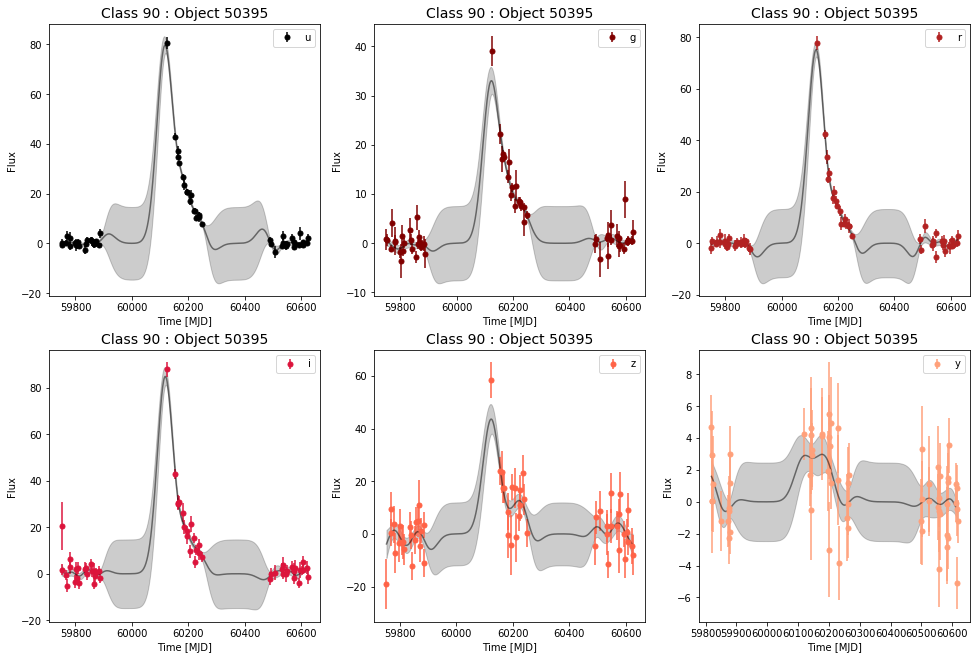

In [13]:
# Plot an example object, either by bandpass or with all bandpasses

# cl = np.random.choice(classes)   
cl = 90
n_objects = len(lightcurves_by_class[cl])

# example_object = np.random.randint(n_objects)
example_object = 100
passbands = (0,1,2,3,4,5)

# plot_lightcurves(cl, example_object, passbands, expand = False, model = True)
plot_lightcurves(cl, example_object, passbands, expand = True, model = True)

## Resting place

In [ ]:
# Note: Go into the code for ExpSquaredKernel to find how it decides which parameters are free
    
#     if ndim ==2:
#         first_dimension = [row[0] for row in x]
#         second_dimension = [row[1] for row in x]
    
#         first_dimension_predict = np.linspace(min(first_dimension), max(first_dimension), 500)
#         second_dimension_predict = np.linspace(min(second_dimension), max(second_dimension), 500)
    
#         x_predict = np.vstack([first_dimension_predict, second_dimension_predict]).T
        
#     else:

# print(data_by_passband)
# y = data_by_passband['flux']
# print(y.shape)